In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(4, activation='relu'))
        
    #model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 8934.6816 - mae: 50.9141 - mape: 3447.4316 - student_loss: 50.7158 - distillation_loss: 8893.1316 - val_mse: 14.6027 - val_mae: 2.6001 - val_mape: 199.6519 - val_student_loss: 1.5683
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 4.0990 - mae: 1.3341 - mape: 81.6105 - student_loss: 1.3334 - distillation_loss: 3.5088 - val_mse: 2.7244 - val_mae: 1.2072 - val_mape: 71.1819 - val_student_loss: 1.2652
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7081 - mae: 1.2202 - mape: 67.9041 - student_loss: 1.2177 - distillation_loss: 2.1509 - val_mse: 2.6005 - val_mae: 1.1881 - val_mape: 70.5997 - val_student_loss: 1.2610
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.6699 - mae: 1.2128 - mape: 67.2966 - student_loss: 1.2120 - distillation_loss: 2.1154 - val_mse: 2.5052 - val_mae: 1.1775 - val_mape: 69.4095 - val_student_loss: 1.2669
E

443/443 [==============================] - 1s 2ms/step - mse: 1.0217 - mae: 0.8054 - mape: 56.9433 - student_loss: 0.8041 - distillation_loss: 0.5777 - val_mse: 0.9815 - val_mae: 0.8063 - val_mape: 62.5996 - val_student_loss: 1.1786
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1215 - mae: 0.8280 - mape: 58.2905 - student_loss: 0.8280 - distillation_loss: 0.6741 - val_mse: 0.9462 - val_mae: 0.7837 - val_mape: 59.1720 - val_student_loss: 1.1603
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0212 - mae: 0.8055 - mape: 57.0523 - student_loss: 0.8075 - distillation_loss: 0.5775 - val_mse: 1.0187 - val_mae: 0.8268 - val_mape: 65.5882 - val_student_loss: 1.1934
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0671 - mae: 0.8193 - mape: 57.7656 - student_loss: 0.8187 - distillation_loss: 0.6151 - val_mse: 0.9367 - val_mae: 0.7675 - val_mape: 55.1333 - val_student_loss: 1.1350
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4636 - mae: 0.5163 - mape: 34.1386 - student_loss: 0.5161 - distillation_loss: 0.0691 - val_mse: 0.4350 - val_mae: 0.5082 - val_mape: 35.0673 - val_student_loss: 0.6354
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4521 - mae: 0.5108 - mape: 33.8537 - student_loss: 0.5110 - distillation_loss: 0.0585 - val_mse: 0.4393 - val_mae: 0.5003 - val_mape: 32.9526 - val_student_loss: 0.6112
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4484 - mae: 0.5072 - mape: 33.5302 - student_loss: 0.5072 - distillation_loss: 0.0548 - val_mse: 0.4353 - val_mae: 0.5079 - val_mape: 34.9946 - val_student_loss: 0.6363
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4516 - mae: 0.5094 - mape: 33.6436 - student_loss: 0.5102 - distillation_loss: 0.0623 - val_mse: 0.4327 - val_mae: 0.5051 - val_mape: 34.6068 - val_student_loss: 0.6337
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4372 - mae: 0.5000 - mape: 33.0082 - student_loss: 0.5004 - distillation_loss: 0.0479 - val_mse: 0.4603 - val_mae: 0.5086 - val_mape: 31.5748 - val_student_loss: 0.6260
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 23.4746 - mse: 4325.1733 - mae: 23.4746 - mape: 1563.5004 - val_loss: 1.1275 - val_mse: 4.3648 - val_mae: 1.1275 - val_mape: 96.0574
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7538 - mse: 3.1872 - mae: 0.7538 - mape: 49.3990 - val_loss: 1.0695 - val_mse: 3.9451 - val_mae: 1.0695 - val_mape: 88.2156
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7383 - mse: 2.4033 - mae: 0.7383 - mape: 47.2219 - val_loss: 1.4791 - val_mse: 4.9090 - val_mae: 1.4791 - val_mape: 114.4995
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7305 - mse: 2.1342 - mae: 0.7305 - mape: 46.4723 - val_loss: 0.5425 - val_mse: 

443/443 [==============================] - 1s 2ms/step - loss: 0.6630 - mse: 1.0763 - mae: 0.6630 - mape: 41.5101 - val_loss: 0.5182 - val_mse: 0.6645 - val_mae: 0.5182 - val_mape: 33.3575
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6767 - mse: 1.0903 - mae: 0.6767 - mape: 42.3075 - val_loss: 0.5269 - val_mse: 0.5462 - val_mae: 0.5269 - val_mape: 35.1512
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6177 - mse: 0.7678 - mae: 0.6177 - mape: 38.2635 - val_loss: 1.4000 - val_mse: 3.2316 - val_mae: 1.4000 - val_mape: 83.3327
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7310 - mse: 1.1685 - mae: 0.7310 - mape: 45.9744 - val_loss: 0.5134 - val_mse: 0.5213 - val_mae: 0.5134 - val_mape: 32.5288
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6910 - mse: 0.9451 - mae: 0.6910 - mape: 43.1120 - val_loss: 0.6503 - val_mse: 0.8366 - val_mae: 0.6503 - val_mape: 35.4181
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7191 - mse: 1.1809 - mae: 0.7191 - mape: 45.0090 - val_loss: 0.5207 - val_mse: 0.5831 - val_mae: 0.5207 - val_mape: 34.3928
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6107 - mse: 0.7658 - mae: 0.6107 - mape: 37.8878 - val_loss: 0.6546 - val_mse: 0.8904 - val_mae: 0.6546 - val_mape: 37.2543
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6413 - mse: 0.9479 - mae: 0.6413 - mape: 39.9908 - val_loss: 0.5386 - val_mse: 0.6647 - val_mae: 0.5386 - val_mape: 30.6173
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6216 - mse: 0.9446 - mae: 0.6216 - mape: 38.3904 - val_loss: 0.8389 - val_mse: 1.2427 - val_mae: 0.8389 - val_mape: 62.5575
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6744 - mse: 1.1125 - mae: 0.6744 - mape: 42.4652 - val_loss: 0.6678 - val_mse: 0.7478 - val_mae: 0.6678 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 12.9504 - mae: 0.7810 - mape: 51.7171 - student_loss: 0.7818 - distillation_loss: 12.3365 - val_mse: 0.6900 - val_mae: 0.5345 - val_mape: 35.8730 - val_student_loss: 0.4506
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 11.2901 - mae: 0.8447 - mape: 55.6884 - student_loss: 0.8459 - distillation_loss: 10.7303 - val_mse: 0.6434 - val_mae: 0.5220 - val_mape: 33.3972 - val_student_loss: 0.3687
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 10.1222 - mae: 0.9146 - mape: 59.7668 - student_loss: 0.9125 - distillation_loss: 9.5651 - val_mse: 0.6029 - val_mae: 0.5173 - val_mape: 32.8843 - val_student_loss: 0.3533
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 7.5663 - mae: 0.8030 - mape: 52.9640 - student_loss: 0.8015 - distillation_loss: 7.0037 - val_mse: 0.5667 - val_mae: 0.5141 - val_mape: 32.4454 - val_student_loss: 0.3435
Epoch 22/10

443/443 [==============================] - 1s 2ms/step - mse: 0.6326 - mae: 0.5792 - mape: 36.8321 - student_loss: 0.5786 - distillation_loss: 0.2288 - val_mse: 0.4979 - val_mae: 0.5185 - val_mape: 29.7874 - val_student_loss: 0.3143
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5680 - mae: 0.5671 - mape: 36.2303 - student_loss: 0.5674 - distillation_loss: 0.1604 - val_mse: 0.5965 - val_mae: 0.6010 - val_mape: 42.0306 - val_student_loss: 0.4835
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7833 - mae: 0.6409 - mape: 41.5196 - student_loss: 0.6396 - distillation_loss: 0.3888 - val_mse: 0.5145 - val_mae: 0.5308 - val_mape: 30.5138 - val_student_loss: 0.3509
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5532 - mae: 0.5612 - mape: 35.8400 - student_loss: 0.5598 - distillation_loss: 0.1466 - val_mse: 0.4778 - val_mae: 0.5143 - val_mape: 31.0674 - val_student_loss: 0.3397
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5058 - mae: 0.5327 - mape: 34.0274 - student_loss: 0.5329 - distillation_loss: 0.0988 - val_mse: 0.5121 - val_mae: 0.5241 - val_mape: 29.4814 - val_student_loss: 0.3050
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5056 - mae: 0.5361 - mape: 34.1761 - student_loss: 0.5357 - distillation_loss: 0.1015 - val_mse: 0.4680 - val_mae: 0.5207 - val_mape: 33.3801 - val_student_loss: 0.3841
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5359 - mae: 0.5524 - mape: 35.3486 - student_loss: 0.5518 - distillation_loss: 0.1303 - val_mse: 0.5318 - val_mae: 0.5321 - val_mape: 29.1392 - val_student_loss: 0.2790
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5763 - mae: 0.5717 - mape: 36.4220 - student_loss: 0.5723 - distillation_loss: 0.1629 - val_mse: 0.4771 - val_mae: 0.5186 - val_mape: 32.1225 - val_student_loss: 0.3518
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5199 - mse: 0.4960 - mae: 0.5199 - mape: 31.9065 - val_loss: 0.5246 - val_mse: 0.4867 - val_mae: 0.5246 - val_mape: 33.0254
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5186 - mse: 0.4928 - mae: 0.5186 - mape: 31.7961 - val_loss: 0.5331 - val_mse: 0.5161 - val_mae: 0.5331 - val_mape: 30.6839
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5224 - mse: 0.4975 - mae: 0.5224 - mape: 32.1912 - val_loss: 0.5488 - val_mse: 0.5482 - val_mae: 0.5488 - val_mape: 30.7152
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5234 - mse: 0.5010 - mae: 0.5234 - mape: 32.2130 - val_loss: 0.5180 - val_mse: 0.4775 - val_mae: 0.5180 - val_mape: 31.6748
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5173 - mse: 0.4879 - mae: 0.5173 - mape: 31.9463 - val_loss: 0.5185 - val_mse: 0.4710 - val_mae: 0.5185 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4916 - mse: 0.4436 - mae: 0.4916 - mape: 30.0192 - val_loss: 0.5048 - val_mse: 0.4424 - val_mae: 0.5048 - val_mape: 32.9396
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4918 - mse: 0.4447 - mae: 0.4918 - mape: 30.1141 - val_loss: 0.5477 - val_mse: 0.5373 - val_mae: 0.5477 - val_mape: 36.5956
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4927 - mse: 0.4474 - mae: 0.4927 - mape: 30.1057 - val_loss: 0.4809 - val_mse: 0.4215 - val_mae: 0.4809 - val_mape: 28.5501
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4893 - mse: 0.4414 - mae: 0.4893 - mape: 29.9505 - val_loss: 0.4803 - val_mse: 0.4210 - val_mae: 0.4803 - val_mape: 28.5188
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4979 - mse: 0.4541 - mae: 0.4979 - mape: 30.3951 - val_loss: 0.5115 - val_mse: 0.4801 - val_mae: 0.5115 - val_mape: 28.6446
Epo

443/443 [==============================] - 1s 2ms/step - mse: 903.1732 - mae: 13.2559 - mape: 874.9976 - student_loss: 13.2078 - distillation_loss: 897.9277 - val_mse: 5.2159 - val_mae: 1.9716 - val_mape: 106.8440 - val_student_loss: 1.6733
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 13.0909 - mae: 2.0280 - mape: 107.9738 - student_loss: 2.0293 - distillation_loss: 12.6917 - val_mse: 4.8541 - val_mae: 1.9578 - val_mape: 102.7042 - val_student_loss: 1.6195
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 11.3433 - mae: 1.9569 - mape: 103.0358 - student_loss: 1.9574 - distillation_loss: 10.9635 - val_mse: 4.5381 - val_mae: 1.8871 - val_mape: 97.8872 - val_student_loss: 1.5438
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 8.8864 - mae: 1.4642 - mape: 81.6832 - student_loss: 1.4648 - distillation_loss: 8.5133 - val_mse: 3.1208 - val_mae: 1.4740 - val_mape: 71.0444 - val_student_loss: 1.1525
Epoch 5/100
443/4

443/443 [==============================] - 1s 2ms/step - mse: 0.4934 - mae: 0.5339 - mape: 34.4149 - student_loss: 0.5337 - distillation_loss: 0.0785 - val_mse: 0.4896 - val_mae: 0.5269 - val_mape: 34.1549 - val_student_loss: 0.5355
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4915 - mae: 0.5319 - mape: 34.1719 - student_loss: 0.5327 - distillation_loss: 0.0792 - val_mse: 0.5307 - val_mae: 0.5738 - val_mape: 40.0493 - val_student_loss: 0.5361
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5088 - mae: 0.5411 - mape: 34.9641 - student_loss: 0.5404 - distillation_loss: 0.0949 - val_mse: 0.4845 - val_mae: 0.5280 - val_mape: 34.8710 - val_student_loss: 0.5177
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4862 - mae: 0.5286 - mape: 34.1077 - student_loss: 0.5283 - distillation_loss: 0.0752 - val_mse: 0.4817 - val_mae: 0.5226 - val_mape: 33.9430 - val_student_loss: 0.5193
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4265 - mae: 0.4962 - mape: 32.7308 - student_loss: 0.4960 - distillation_loss: 0.0403 - val_mse: 0.4468 - val_mae: 0.5207 - val_mape: 36.3714 - val_student_loss: 0.4744
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4305 - mae: 0.4979 - mape: 32.7383 - student_loss: 0.4975 - distillation_loss: 0.0441 - val_mse: 0.4327 - val_mae: 0.5028 - val_mape: 34.1795 - val_student_loss: 0.4484
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4349 - mae: 0.5012 - mape: 32.9991 - student_loss: 0.5009 - distillation_loss: 0.0495 - val_mse: 0.4449 - val_mae: 0.4918 - val_mape: 31.1370 - val_student_loss: 0.4385
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4334 - mae: 0.5003 - mape: 32.8122 - student_loss: 0.4989 - distillation_loss: 0.0480 - val_mse: 0.4424 - val_mae: 0.4953 - val_mape: 32.3357 - val_student_loss: 0.4178
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4268 - mae: 0.4971 - mape: 32.8419 - student_loss: 0.4965 - distillation_loss: 0.0410 - val_mse: 0.4268 - val_mae: 0.4869 - val_mape: 31.7838 - val_student_loss: 0.4348
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.3418 - mse: 293.3699 - mae: 7.3418 - mape: 459.0864 - val_loss: 0.7643 - val_mse: 0.9311 - val_mae: 0.7643 - val_mape: 51.9882
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7526 - mse: 0.9985 - mae: 0.7526 - mape: 50.4152 - val_loss: 0.7554 - val_mse: 0.9348 - val_mae: 0.7554 - val_mape: 48.5825
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7305 - mse: 0.9096 - mae: 0.7305 - mape: 48.7191 - val_loss: 0.7274 - val_mse: 0.8239 - val_mae: 0.7274 - val_mape: 51.5013
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7038 - mse: 0.8275 - mae: 0.7038 - mape: 47.0344 - val_loss: 0.6923 - val_mse: 0.761

443/443 [==============================] - 1s 2ms/step - loss: 0.4952 - mse: 0.4541 - mae: 0.4952 - mape: 29.8651 - val_loss: 0.4846 - val_mse: 0.4250 - val_mae: 0.4846 - val_mape: 30.4177
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4966 - mse: 0.4542 - mae: 0.4966 - mape: 30.1663 - val_loss: 0.4848 - val_mse: 0.4269 - val_mae: 0.4848 - val_mape: 30.2093
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4990 - mse: 0.4567 - mae: 0.4990 - mape: 30.2643 - val_loss: 0.4823 - val_mse: 0.4251 - val_mae: 0.4823 - val_mape: 30.0314
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4921 - mse: 0.4470 - mae: 0.4921 - mape: 29.9905 - val_loss: 0.4955 - val_mse: 0.4340 - val_mae: 0.4955 - val_mape: 31.5566
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4960 - mse: 0.4529 - mae: 0.4960 - mape: 30.0746 - val_loss: 0.4903 - val_mse: 0.4237 - val_mae: 0.4903 - val_mape: 31.4616
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4900 - mse: 0.4417 - mae: 0.4900 - mape: 30.0447 - val_loss: 0.4806 - val_mse: 0.4376 - val_mae: 0.4806 - val_mape: 28.3979
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4881 - mse: 0.4398 - mae: 0.4881 - mape: 29.7749 - val_loss: 0.4781 - val_mse: 0.4309 - val_mae: 0.4781 - val_mape: 28.4977
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4861 - mse: 0.4352 - mae: 0.4861 - mape: 29.6986 - val_loss: 0.4784 - val_mse: 0.4331 - val_mae: 0.4784 - val_mape: 28.3236
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4887 - mse: 0.4407 - mae: 0.4887 - mape: 29.8270 - val_loss: 0.4764 - val_mse: 0.4233 - val_mae: 0.4764 - val_mape: 28.8801
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4882 - mse: 0.4394 - mae: 0.4882 - mape: 29.7716 - val_loss: 0.4787 - val_mse: 0.4178 - val_mae: 0.4787 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5304 - mae: 0.5516 - mape: 35.5189 - student_loss: 0.5526 - distillation_loss: 0.1180 - val_mse: 0.5508 - val_mae: 0.5703 - val_mape: 38.7658 - val_student_loss: 0.4229
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5183 - mae: 0.5421 - mape: 34.8285 - student_loss: 0.5438 - distillation_loss: 0.1059 - val_mse: 0.5234 - val_mae: 0.5455 - val_mape: 36.5458 - val_student_loss: 0.4090
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3441 - mae: 0.6953 - mape: 45.3894 - student_loss: 0.6944 - distillation_loss: 0.9320 - val_mse: 0.5351 - val_mae: 0.5363 - val_mape: 33.6354 - val_student_loss: 0.3415
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5084 - mae: 0.5377 - mape: 34.7559 - student_loss: 0.5398 - distillation_loss: 0.1023 - val_mse: 0.5534 - val_mae: 0.5400 - val_mape: 33.0952 - val_student_loss: 0.3068
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.1125 - mae: 0.6882 - mape: 44.0316 - student_loss: 0.6878 - distillation_loss: 0.7080 - val_mse: 0.6441 - val_mae: 0.5488 - val_mape: 31.7400 - val_student_loss: 0.2736
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8390 - mae: 0.6472 - mape: 41.8168 - student_loss: 0.6464 - distillation_loss: 0.4332 - val_mse: 0.5757 - val_mae: 0.6008 - val_mape: 43.1859 - val_student_loss: 0.5628
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6090 - mae: 0.5839 - mape: 37.5956 - student_loss: 0.5910 - distillation_loss: 0.2259 - val_mse: 26.6677 - val_mae: 3.9843 - val_mape: 285.5118 - val_student_loss: 3.2124
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1330 - mae: 0.6697 - mape: 42.9948 - student_loss: 0.6700 - distillation_loss: 0.7275 - val_mse: 0.5224 - val_mae: 0.5524 - val_mape: 37.5682 - val_student_loss: 0.4603
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.6885 - mae: 0.6085 - mape: 39.0755 - student_loss: 0.6074 - distillation_loss: 0.2878 - val_mse: 0.7626 - val_mae: 0.6365 - val_mape: 34.6624 - val_student_loss: 0.2718
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9374 - mae: 0.6882 - mape: 44.1399 - student_loss: 0.6880 - distillation_loss: 0.5326 - val_mse: 0.5497 - val_mae: 0.5830 - val_mape: 41.2767 - val_student_loss: 0.5333
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5943 - mae: 0.5758 - mape: 36.7738 - student_loss: 0.5752 - distillation_loss: 0.1878 - val_mse: 0.5250 - val_mae: 0.5283 - val_mape: 33.1060 - val_student_loss: 0.3696
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6157 - mae: 0.5933 - mape: 37.8730 - student_loss: 0.5924 - distillation_loss: 0.2122 - val_mse: 0.5303 - val_mae: 0.5257 - val_mape: 31.9669 - val_student_loss: 0.3372
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5478 - mse: 0.5814 - mae: 0.5478 - mape: 32.9938 - val_loss: 0.5304 - val_mse: 0.5308 - val_mae: 0.5304 - val_mape: 33.3096
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5782 - mse: 0.6389 - mae: 0.5782 - mape: 35.2564 - val_loss: 0.5447 - val_mse: 0.6004 - val_mae: 0.5447 - val_mape: 30.4246
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5619 - mse: 0.5892 - mae: 0.5619 - mape: 33.8858 - val_loss: 0.7286 - val_mse: 0.8379 - val_mae: 0.7286 - val_mape: 53.7281
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5687 - mse: 0.6301 - mae: 0.5687 - mape: 34.5625 - val_loss: 0.5325 - val_mse: 0.5747 - val_mae: 0.5325 - val_mape: 30.2704
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5473 - mse: 0.5829 - mae: 0.5473 - mape: 32.7534 - val_loss: 0.5618 - val_mse: 0.6256 - val_mae: 0.5618 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5482 - mse: 0.5901 - mae: 0.5482 - mape: 33.0515 - val_loss: 0.5850 - val_mse: 0.5752 - val_mae: 0.5850 - val_mape: 39.9233
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5503 - mse: 0.6125 - mae: 0.5503 - mape: 33.3573 - val_loss: 0.5510 - val_mse: 0.5326 - val_mae: 0.5510 - val_mape: 37.0340
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5572 - mse: 0.6007 - mae: 0.5572 - mape: 33.5717 - val_loss: 0.6193 - val_mse: 0.6269 - val_mae: 0.6193 - val_mape: 43.3482
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5485 - mse: 0.6139 - mae: 0.5485 - mape: 33.0785 - val_loss: 0.5441 - val_mse: 0.5454 - val_mae: 0.5441 - val_mape: 34.3199
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5636 - mse: 0.6659 - mae: 0.5636 - mape: 34.1355 - val_loss: 0.5577 - val_mse: 0.5499 - val_mae: 0.5577 - val_mape: 36.5452
Epo

443/443 [==============================] - 2s 3ms/step - mse: 364.2724 - mae: 9.0617 - mape: 617.9714 - student_loss: 9.0275 - distillation_loss: 361.5706 - val_mse: 2.9046 - val_mae: 1.3032 - val_mape: 70.1784 - val_student_loss: 0.9731
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.3812 - mae: 1.2752 - mape: 65.8982 - student_loss: 1.2745 - distillation_loss: 2.8310 - val_mse: 2.7389 - val_mae: 1.2921 - val_mape: 66.9047 - val_student_loss: 1.0049
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.1530 - mae: 1.2513 - mape: 64.0278 - student_loss: 1.2520 - distillation_loss: 2.6024 - val_mse: 2.6611 - val_mae: 1.2620 - val_mape: 65.9472 - val_student_loss: 0.9708
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.9479 - mae: 1.2214 - mape: 62.4094 - student_loss: 1.2200 - distillation_loss: 2.4018 - val_mse: 2.5185 - val_mae: 1.2329 - val_mape: 63.1246 - val_student_loss: 0.9655
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.9603 - mae: 0.7851 - mape: 55.9701 - student_loss: 0.7865 - distillation_loss: 0.5194 - val_mse: 0.9468 - val_mae: 0.7757 - val_mape: 54.4577 - val_student_loss: 0.5928
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9556 - mae: 0.7832 - mape: 55.9437 - student_loss: 0.7826 - distillation_loss: 0.5124 - val_mse: 0.9478 - val_mae: 0.7795 - val_mape: 55.3598 - val_student_loss: 0.5896
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9555 - mae: 0.7831 - mape: 55.8675 - student_loss: 0.7841 - distillation_loss: 0.5137 - val_mse: 0.9453 - val_mae: 0.7787 - val_mape: 55.3578 - val_student_loss: 0.5877
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9520 - mae: 0.7827 - mape: 56.0466 - student_loss: 0.7828 - distillation_loss: 0.5072 - val_mse: 0.9479 - val_mae: 0.7707 - val_mape: 53.1145 - val_student_loss: 0.5926
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4438 - mae: 0.5055 - mape: 33.6716 - student_loss: 0.5052 - distillation_loss: 0.0528 - val_mse: 0.4262 - val_mae: 0.4940 - val_mape: 32.1665 - val_student_loss: 0.3699
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4482 - mae: 0.5081 - mape: 33.7424 - student_loss: 0.5076 - distillation_loss: 0.0597 - val_mse: 0.4398 - val_mae: 0.5128 - val_mape: 34.9173 - val_student_loss: 0.3507
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4478 - mae: 0.5076 - mape: 33.7719 - student_loss: 0.5068 - distillation_loss: 0.0580 - val_mse: 0.4263 - val_mae: 0.4921 - val_mape: 31.5206 - val_student_loss: 0.3721
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4431 - mae: 0.5047 - mape: 33.5531 - student_loss: 0.5044 - distillation_loss: 0.0543 - val_mse: 0.4305 - val_mae: 0.4927 - val_mape: 31.3200 - val_student_loss: 0.3848
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4616 - mae: 0.5130 - mape: 33.7633 - student_loss: 0.5132 - distillation_loss: 0.0738 - val_mse: 0.4306 - val_mae: 0.5012 - val_mape: 33.6744 - val_student_loss: 0.3705
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 365.8663 - mse: 313692.6875 - mae: 365.8663 - mape: 24213.4414 - val_loss: 83.8089 - val_mse: 12782.2383 - val_mae: 83.8089 - val_mape: 5521.2686
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 16.0660 - mse: 1728.8562 - mae: 16.0660 - mape: 1015.6625 - val_loss: 1.1645 - val_mse: 2.2181 - val_mae: 1.1645 - val_mape: 51.9633
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0215 - mse: 1.9946 - mae: 1.0215 - mape: 46.6213 - val_loss: 0.9418 - val_mse: 1.5544 - val_mae: 0.9418 - val_mape: 44.6325
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8662 - mse: 1.4277 - mae: 0.8662 - mape: 43.8643 - val_loss:

443/443 [==============================] - 1s 2ms/step - loss: 0.5823 - mse: 0.6332 - mae: 0.5823 - mape: 34.0069 - val_loss: 0.5587 - val_mse: 0.5777 - val_mae: 0.5587 - val_mape: 31.4157
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5746 - mse: 0.6300 - mae: 0.5746 - mape: 33.4909 - val_loss: 0.5741 - val_mse: 0.6175 - val_mae: 0.5741 - val_mape: 30.4176
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5719 - mse: 0.6242 - mae: 0.5719 - mape: 33.4787 - val_loss: 0.6163 - val_mse: 0.7079 - val_mae: 0.6163 - val_mape: 31.3698
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5700 - mse: 0.6225 - mae: 0.5700 - mape: 33.4352 - val_loss: 0.5525 - val_mse: 0.5728 - val_mae: 0.5525 - val_mape: 30.3729
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5742 - mse: 0.6298 - mae: 0.5742 - mape: 33.9138 - val_loss: 0.5484 - val_mse: 0.5298 - val_mae: 0.5484 - val_mape: 33.6367
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5473 - mse: 0.8170 - mae: 0.5473 - mape: 32.7285 - val_loss: 0.5303 - val_mse: 0.4867 - val_mae: 0.5303 - val_mape: 32.9615
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5445 - mse: 0.7903 - mae: 0.5445 - mape: 32.3869 - val_loss: 0.5482 - val_mse: 0.5096 - val_mae: 0.5482 - val_mape: 34.6706
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5441 - mse: 0.8206 - mae: 0.5441 - mape: 32.4082 - val_loss: 0.5324 - val_mse: 0.5156 - val_mae: 0.5324 - val_mape: 30.1723
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5450 - mse: 0.8333 - mae: 0.5450 - mape: 32.4640 - val_loss: 0.5453 - val_mse: 0.5496 - val_mae: 0.5453 - val_mape: 29.6116
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5444 - mse: 0.8391 - mae: 0.5444 - mape: 32.4127 - val_loss: 0.5540 - val_mse: 0.5607 - val_mae: 0.5540 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3647 - mae: 0.6712 - mape: 44.2893 - student_loss: 0.6710 - distillation_loss: 0.9539 - val_mse: 0.9403 - val_mae: 0.6022 - val_mape: 35.3119 - val_student_loss: 0.7725
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3879 - mae: 0.7080 - mape: 46.5464 - student_loss: 0.7099 - distillation_loss: 0.9767 - val_mse: 0.8699 - val_mae: 0.5938 - val_mape: 34.2462 - val_student_loss: 0.8522
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1913 - mae: 0.6768 - mape: 44.5037 - student_loss: 0.6780 - distillation_loss: 0.7783 - val_mse: 1.2579 - val_mae: 0.8210 - val_mape: 58.0756 - val_student_loss: 0.9511
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1175 - mae: 0.6812 - mape: 44.8250 - student_loss: 0.6821 - distillation_loss: 0.7033 - val_mse: 1.4636 - val_mae: 0.9141 - val_mape: 47.1460 - val_student_loss: 1.4966
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.5787 - mae: 0.5740 - mape: 36.9936 - student_loss: 0.5738 - distillation_loss: 0.1667 - val_mse: 0.4845 - val_mae: 0.5177 - val_mape: 33.5809 - val_student_loss: 0.7143
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6065 - mae: 0.5765 - mape: 37.0911 - student_loss: 0.5764 - distillation_loss: 0.1898 - val_mse: 0.4888 - val_mae: 0.5292 - val_mape: 34.9476 - val_student_loss: 0.6973
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 1.0089 - mae: 0.6650 - mape: 43.0865 - student_loss: 0.6639 - distillation_loss: 0.5976 - val_mse: 0.4920 - val_mae: 0.5294 - val_mape: 34.5350 - val_student_loss: 0.6889
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6691 - mae: 0.5955 - mape: 38.2459 - student_loss: 0.5949 - distillation_loss: 0.2556 - val_mse: 0.4846 - val_mae: 0.5190 - val_mape: 33.4496 - val_student_loss: 0.6890
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.7171 - mae: 0.6276 - mape: 40.5662 - student_loss: 0.6280 - distillation_loss: 0.3199 - val_mse: 0.7089 - val_mae: 0.6792 - val_mape: 48.6265 - val_student_loss: 0.8811
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7598 - mae: 0.6277 - mape: 40.5194 - student_loss: 0.6271 - distillation_loss: 0.3579 - val_mse: 0.5190 - val_mae: 0.5477 - val_mape: 36.4205 - val_student_loss: 0.7262
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0982 - mae: 0.6723 - mape: 43.3224 - student_loss: 0.6710 - distillation_loss: 0.6741 - val_mse: 0.5181 - val_mae: 0.5183 - val_mape: 29.7862 - val_student_loss: 0.7387
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7537 - mae: 0.5983 - mape: 38.5666 - student_loss: 0.5987 - distillation_loss: 0.3399 - val_mse: 0.5141 - val_mae: 0.5109 - val_mape: 31.8779 - val_student_loss: 0.6913
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7027 - mse: 1.1123 - mae: 0.7027 - mape: 44.0066 - val_loss: 0.5234 - val_mse: 0.5794 - val_mae: 0.5234 - val_mape: 32.9305
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6526 - mse: 0.9510 - mae: 0.6526 - mape: 40.7239 - val_loss: 0.7457 - val_mse: 0.8867 - val_mae: 0.7457 - val_mape: 53.4965
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7143 - mse: 1.0807 - mae: 0.7143 - mape: 44.8154 - val_loss: 0.5929 - val_mse: 0.7116 - val_mae: 0.5929 - val_mape: 31.1575
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7931 - mse: 1.2041 - mae: 0.7931 - mape: 50.3544 - val_loss: 0.6554 - val_mse: 0.8452 - val_mae: 0.6554 - val_mape: 34.8894
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7261 - mse: 1.0470 - mae: 0.7261 - mape: 45.9141 - val_loss: 0.5424 - val_mse: 0.5609 - val_mae: 0.5424 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7153 - mse: 0.9974 - mae: 0.7153 - mape: 45.0488 - val_loss: 0.5339 - val_mse: 0.5144 - val_mae: 0.5339 - val_mape: 34.6588
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8148 - mse: 1.2437 - mae: 0.8148 - mape: 52.4139 - val_loss: 0.7679 - val_mse: 1.0257 - val_mae: 0.7679 - val_mape: 40.4235
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6904 - mse: 0.9364 - mae: 0.6904 - mape: 43.1259 - val_loss: 0.5217 - val_mse: 0.5027 - val_mae: 0.5217 - val_mape: 33.0344
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7308 - mse: 1.1108 - mae: 0.7308 - mape: 46.1004 - val_loss: 0.5823 - val_mse: 0.5607 - val_mae: 0.5823 - val_mape: 39.6441
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7256 - mse: 1.0527 - mae: 0.7256 - mape: 45.6603 - val_loss: 0.7149 - val_mse: 0.8266 - val_mae: 0.7149 - val_mape: 50.2541
Epo

443/443 [==============================] - 1s 2ms/step - mse: 1827.3572 - mae: 17.7105 - mape: 1181.6582 - student_loss: 17.6759 - distillation_loss: 1819.8407 - val_mse: 66.6614 - val_mae: 6.8759 - val_mape: 447.2961 - val_student_loss: 6.2713
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 53.8004 - mae: 6.1078 - mape: 411.0477 - student_loss: 6.1078 - distillation_loss: 52.8748 - val_mse: 44.9751 - val_mae: 5.6170 - val_mape: 368.0031 - val_student_loss: 5.5284
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 38.4372 - mae: 5.1056 - mape: 346.3111 - student_loss: 5.1062 - distillation_loss: 37.7391 - val_mse: 33.6923 - val_mae: 4.7816 - val_mape: 314.6728 - val_student_loss: 4.8186
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 29.8197 - mae: 4.4114 - mape: 301.2152 - student_loss: 4.4102 - distillation_loss: 29.1649 - val_mse: 25.3099 - val_mae: 4.1394 - val_mape: 271.7949 - val_student_loss: 4.5485
Epoch

443/443 [==============================] - 1s 2ms/step - mse: 0.5924 - mae: 0.5719 - mape: 36.9165 - student_loss: 0.5722 - distillation_loss: 0.1840 - val_mse: 0.6432 - val_mae: 0.5753 - val_mape: 31.2768 - val_student_loss: 1.3477
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6367 - mae: 0.5879 - mape: 38.0470 - student_loss: 0.5880 - distillation_loss: 0.2338 - val_mse: 0.6204 - val_mae: 0.6259 - val_mape: 43.3958 - val_student_loss: 0.6036
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5908 - mae: 0.5737 - mape: 37.0172 - student_loss: 0.5729 - distillation_loss: 0.1871 - val_mse: 0.5892 - val_mae: 0.6045 - val_mape: 41.4997 - val_student_loss: 0.7308
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 13.2068 - mae: 1.4343 - mape: 95.3636 - student_loss: 1.4306 - distillation_loss: 12.8029 - val_mse: 0.5199 - val_mae: 0.5331 - val_mape: 32.8922 - val_student_loss: 0.9277
Epoch 38/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.6283 - mae: 0.5947 - mape: 38.4953 - student_loss: 0.5960 - distillation_loss: 0.2267 - val_mse: 1.4059 - val_mae: 0.8712 - val_mape: 45.7070 - val_student_loss: 1.8230
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 3.8605 - mae: 0.9835 - mape: 64.5020 - student_loss: 0.9818 - distillation_loss: 3.4798 - val_mse: 0.5261 - val_mae: 0.5513 - val_mape: 35.9628 - val_student_loss: 0.7995
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5538 - mae: 0.5661 - mape: 36.5653 - student_loss: 0.5659 - distillation_loss: 0.1559 - val_mse: 0.5187 - val_mae: 0.5372 - val_mape: 33.9896 - val_student_loss: 0.8490
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0271 - mae: 0.7092 - mape: 46.4283 - student_loss: 0.7094 - distillation_loss: 0.6265 - val_mse: 0.6234 - val_mae: 0.5618 - val_mape: 30.5462 - val_student_loss: 1.2335
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5754 - mae: 0.5637 - mape: 36.5072 - student_loss: 0.5627 - distillation_loss: 0.1764 - val_mse: 0.5469 - val_mae: 0.5695 - val_mape: 38.0051 - val_student_loss: 0.7188
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 48.3027 - mse: 11660.4756 - mae: 48.3027 - mape: 3190.1931 - val_loss: 1.1893 - val_mse: 2.7493 - val_mae: 1.1893 - val_mape: 63.2150
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1521 - mse: 2.7149 - mae: 1.1521 - mape: 62.3488 - val_loss: 1.1028 - val_mse: 2.4483 - val_mae: 1.1028 - val_mape: 60.8366
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0621 - mse: 2.2963 - mae: 1.0621 - mape: 57.1264 - val_loss: 1.0057 - val_mse: 1.9938 - val_mae: 1.0057 - val_mape: 55.3646
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9833 - mse: 1.9393 - mae: 0.9833 - mape: 53.1588 - val_loss: 0.9204 - val_mse: 

443/443 [==============================] - 1s 2ms/step - loss: 0.5075 - mse: 0.4657 - mae: 0.5075 - mape: 31.3489 - val_loss: 0.5048 - val_mse: 0.4776 - val_mae: 0.5048 - val_mape: 30.0072
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5049 - mse: 0.4622 - mae: 0.5049 - mape: 31.2259 - val_loss: 0.5059 - val_mse: 0.4819 - val_mae: 0.5059 - val_mape: 29.6884
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5058 - mse: 0.4652 - mae: 0.5058 - mape: 31.2544 - val_loss: 0.5052 - val_mse: 0.4824 - val_mae: 0.5052 - val_mape: 29.5171
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5125 - mse: 0.4716 - mae: 0.5125 - mape: 31.5700 - val_loss: 0.5092 - val_mse: 0.4747 - val_mae: 0.5092 - val_mape: 31.4738
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5046 - mse: 0.4627 - mae: 0.5046 - mape: 31.2605 - val_loss: 0.5080 - val_mse: 0.4894 - val_mae: 0.5080 - val_mape: 29.3198
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4928 - mse: 0.4419 - mae: 0.4928 - mape: 30.3640 - val_loss: 0.4978 - val_mse: 0.4615 - val_mae: 0.4978 - val_mape: 29.7846
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.4528 - mae: 0.4987 - mape: 30.6646 - val_loss: 0.4979 - val_mse: 0.4674 - val_mae: 0.4979 - val_mape: 29.0578
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4920 - mse: 0.4417 - mae: 0.4920 - mape: 30.2998 - val_loss: 0.4935 - val_mse: 0.4545 - val_mae: 0.4935 - val_mape: 29.6437
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4920 - mse: 0.4404 - mae: 0.4920 - mape: 30.4706 - val_loss: 0.4985 - val_mse: 0.4691 - val_mae: 0.4985 - val_mape: 29.0315
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4926 - mse: 0.4412 - mae: 0.4926 - mape: 30.4413 - val_loss: 0.4943 - val_mse: 0.4600 - val_mae: 0.4943 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7807 - mape: 55.9976 - student_loss: 0.7804 - distillation_loss: 0.5120 - val_mse: 0.9599 - val_mae: 0.7903 - val_mape: 56.3688 - val_student_loss: 0.7847
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7803 - mape: 55.9250 - student_loss: 0.7793 - distillation_loss: 0.5126 - val_mse: 0.9598 - val_mae: 0.7912 - val_mape: 56.5943 - val_student_loss: 0.7878
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7812 - mape: 56.1383 - student_loss: 0.7846 - distillation_loss: 0.5167 - val_mse: 0.9603 - val_mae: 0.7898 - val_mape: 56.2139 - val_student_loss: 0.7825
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7805 - mape: 55.9722 - student_loss: 0.7803 - distillation_loss: 0.5113 - val_mse: 0.9601 - val_mae: 0.7902 - val_mape: 56.3234 - val_student_loss: 0.7840
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7808 - mape: 56.0407 - student_loss: 0.7800 - distillation_loss: 0.5137 - val_mse: 0.9603 - val_mae: 0.7898 - val_mape: 56.2001 - val_student_loss: 0.7824
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7806 - mape: 55.9847 - student_loss: 0.7819 - distillation_loss: 0.5132 - val_mse: 0.9602 - val_mae: 0.7900 - val_mape: 56.2604 - val_student_loss: 0.7832
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7810 - mape: 56.0718 - student_loss: 0.7798 - distillation_loss: 0.5127 - val_mse: 0.9607 - val_mae: 0.7890 - val_mape: 55.9782 - val_student_loss: 0.7793
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9509 - mae: 0.7798 - mape: 55.7763 - student_loss: 0.7801 - distillation_loss: 0.5129 - val_mse: 0.9598 - val_mae: 0.7917 - val_mape: 56.7161 - val_student_loss: 0.7894
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7810 - mape: 56.0842 - student_loss: 0.7820 - distillation_loss: 0.5137 - val_mse: 0.9603 - val_mae: 0.7898 - val_mape: 56.2191 - val_student_loss: 0.7826
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9509 - mae: 0.7804 - mape: 55.9224 - student_loss: 0.7807 - distillation_loss: 0.5130 - val_mse: 0.9599 - val_mae: 0.7910 - val_mape: 56.5365 - val_student_loss: 0.7870
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7810 - mape: 56.0657 - student_loss: 0.7816 - distillation_loss: 0.5128 - val_mse: 0.9602 - val_mae: 0.7900 - val_mape: 56.2564 - val_student_loss: 0.7831
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9509 - mae: 0.7804 - mape: 55.9061 - student_loss: 0.7804 - distillation_loss: 0.5146 - val_mse: 0.9599 - val_mae: 0.7909 - val_mape: 56.5189 - val_student_loss: 0.7867
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6205 - mse: 0.8748 - mae: 0.6205 - mape: 38.1633 - val_loss: 0.9824 - val_mse: 1.4048 - val_mae: 0.9824 - val_mape: 74.0061
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7686 - mse: 1.0911 - mae: 0.7686 - mape: 48.7886 - val_loss: 0.6348 - val_mse: 0.7314 - val_mae: 0.6348 - val_mape: 33.4442
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7984 - mse: 1.3043 - mae: 0.7984 - mape: 50.2854 - val_loss: 1.1583 - val_mse: 2.0657 - val_mae: 1.1583 - val_mape: 86.3837
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7362 - mse: 1.2208 - mae: 0.7362 - mape: 46.5232 - val_loss: 0.6416 - val_mse: 0.6160 - val_mae: 0.6416 - val_mape: 46.7840
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8076 - mse: 1.2904 - mae: 0.8076 - mape: 51.7314 - val_loss: 0.6751 - val_mse: 0.6737 - val_mae: 0.6751 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.8006 - mse: 1.3213 - mae: 0.8006 - mape: 50.9443 - val_loss: 0.6991 - val_mse: 0.7247 - val_mae: 0.6991 - val_mape: 51.6169
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7525 - mse: 1.1154 - mae: 0.7525 - mape: 47.8422 - val_loss: 0.5205 - val_mse: 0.4832 - val_mae: 0.5205 - val_mape: 32.9891
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7515 - mse: 1.2279 - mae: 0.7515 - mape: 47.5555 - val_loss: 0.5635 - val_mse: 0.6024 - val_mae: 0.5635 - val_mape: 30.9010
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7119 - mse: 0.9892 - mae: 0.7119 - mape: 44.6069 - val_loss: 0.6503 - val_mse: 0.7579 - val_mae: 0.6503 - val_mape: 35.2865
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8109 - mse: 1.3415 - mae: 0.8109 - mape: 51.3112 - val_loss: 0.9720 - val_mse: 1.4542 - val_mae: 0.9720 - val_mape: 54.5020
Epo

443/443 [==============================] - 1s 2ms/step - mse: 13730.9795 - mae: 63.0263 - mape: 4191.1519 - student_loss: 62.7821 - distillation_loss: 13668.6015 - val_mse: 76.6695 - val_mae: 4.2859 - val_mape: 263.6315 - val_student_loss: 1.3101
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 18.9250 - mae: 2.5622 - mape: 144.3448 - student_loss: 2.5630 - distillation_loss: 18.2159 - val_mse: 5.7805 - val_mae: 2.1081 - val_mape: 114.1981 - val_student_loss: 2.2615
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 5.7462 - mae: 2.1085 - mape: 112.2738 - student_loss: 2.1104 - distillation_loss: 5.2527 - val_mse: 5.1496 - val_mae: 2.0485 - val_mape: 110.3365 - val_student_loss: 2.2399
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 5.3052 - mae: 2.0702 - mape: 109.5514 - student_loss: 2.0706 - distillation_loss: 4.8306 - val_mse: 5.0212 - val_mae: 2.0159 - val_mape: 108.0945 - val_student_loss: 2.2104
Epoch 5/10

443/443 [==============================] - 1s 2ms/step - mse: 0.4776 - mae: 0.5215 - mape: 33.8712 - student_loss: 0.5219 - distillation_loss: 0.0735 - val_mse: 0.4404 - val_mae: 0.5146 - val_mape: 35.2843 - val_student_loss: 0.5183
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4750 - mae: 0.5196 - mape: 33.6953 - student_loss: 0.5192 - distillation_loss: 0.0704 - val_mse: 0.4371 - val_mae: 0.4944 - val_mape: 31.6554 - val_student_loss: 0.5350
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4746 - mae: 0.5196 - mape: 33.6687 - student_loss: 0.5194 - distillation_loss: 0.0725 - val_mse: 0.4286 - val_mae: 0.4989 - val_mape: 33.2007 - val_student_loss: 0.5233
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4756 - mae: 0.5203 - mape: 33.6644 - student_loss: 0.5205 - distillation_loss: 0.0708 - val_mse: 0.4280 - val_mae: 0.4992 - val_mape: 33.2408 - val_student_loss: 0.5193
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4464 - mae: 0.5044 - mape: 33.2816 - student_loss: 0.5033 - distillation_loss: 0.0577 - val_mse: 0.3972 - val_mae: 0.4729 - val_mape: 30.7182 - val_student_loss: 0.5837
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4539 - mae: 0.5086 - mape: 33.5232 - student_loss: 0.5081 - distillation_loss: 0.0636 - val_mse: 0.3977 - val_mae: 0.4860 - val_mape: 33.2424 - val_student_loss: 0.5512
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4355 - mae: 0.4995 - mape: 33.1283 - student_loss: 0.4995 - distillation_loss: 0.0476 - val_mse: 0.4026 - val_mae: 0.4873 - val_mape: 32.9448 - val_student_loss: 0.5399
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4507 - mae: 0.5075 - mape: 33.4383 - student_loss: 0.5079 - distillation_loss: 0.0633 - val_mse: 0.4010 - val_mae: 0.4894 - val_mape: 33.5340 - val_student_loss: 0.5435
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4330 - mae: 0.4974 - mape: 32.8027 - student_loss: 0.4967 - distillation_loss: 0.0470 - val_mse: 0.3943 - val_mae: 0.4793 - val_mape: 32.0029 - val_student_loss: 0.5447
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 236.9246 - mse: 144341.6406 - mae: 236.9246 - mape: 15672.6387 - val_loss: 4.8028 - val_mse: 100.7154 - val_mae: 4.8028 - val_mape: 312.3232
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5305 - mse: 9.0177 - mae: 1.5305 - mape: 96.7508 - val_loss: 0.9551 - val_mse: 1.6457 - val_mae: 0.9551 - val_mape: 52.3336
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9518 - mse: 1.7351 - mae: 0.9518 - mape: 51.3417 - val_loss: 0.9007 - val_mse: 1.4809 - val_mae: 0.9007 - val_mape: 48.9447
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9062 - mse: 1.4825 - mae: 0.9062 - mape: 49.3618 - val_loss: 0.8552 - va

443/443 [==============================] - 1s 2ms/step - loss: 0.5843 - mse: 0.7522 - mae: 0.5843 - mape: 34.4442 - val_loss: 0.5829 - val_mse: 3.6860 - val_mae: 0.5829 - val_mape: 33.3751
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5747 - mse: 0.7463 - mae: 0.5747 - mape: 33.9324 - val_loss: 0.5815 - val_mse: 3.8626 - val_mae: 0.5815 - val_mape: 35.4559
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5680 - mse: 0.7633 - mae: 0.5680 - mape: 33.5485 - val_loss: 0.5746 - val_mse: 4.0432 - val_mae: 0.5746 - val_mape: 34.6870
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5649 - mse: 0.7566 - mae: 0.5649 - mape: 33.3480 - val_loss: 0.5725 - val_mse: 4.5862 - val_mae: 0.5725 - val_mape: 34.5697
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5607 - mse: 0.7618 - mae: 0.5607 - mape: 33.2555 - val_loss: 0.5713 - val_mse: 4.8558 - val_mae: 0.5713 - val_mape: 32.9241
Epo

443/443 [==============================] - 1s 2ms/step - loss: 0.5407 - mse: 1.3237 - mae: 0.5407 - mape: 32.8294 - val_loss: 0.5964 - val_mse: 17.6456 - val_mae: 0.5964 - val_mape: 35.4086
Epoch 81/100
443/443 [==============================] - 1s 1ms/step - loss: 0.5338 - mse: 1.3387 - mae: 0.5338 - mape: 32.2798 - val_loss: 0.6082 - val_mse: 16.7972 - val_mae: 0.6082 - val_mape: 39.4132
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5333 - mse: 1.3945 - mae: 0.5333 - mape: 32.2855 - val_loss: 0.5937 - val_mse: 17.1014 - val_mae: 0.5937 - val_mape: 36.6637
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5330 - mse: 1.3394 - mae: 0.5330 - mape: 32.3086 - val_loss: 0.6516 - val_mse: 19.0045 - val_mae: 0.6516 - val_mape: 37.1621
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5373 - mse: 1.3877 - mae: 0.5373 - mape: 32.3997 - val_loss: 0.5997 - val_mse: 18.3169 - val_mae: 0.5997 - val_mape: 35.822

Epoch 17/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1994 - mae: 0.7218 - mape: 48.0718 - student_loss: 0.7213 - distillation_loss: 0.7903 - val_mse: 0.7278 - val_mae: 0.6559 - val_mape: 44.0790 - val_student_loss: 0.5758
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7275 - mae: 0.6115 - mape: 40.0353 - student_loss: 0.6118 - distillation_loss: 0.3220 - val_mse: 0.6449 - val_mae: 0.5883 - val_mape: 35.6044 - val_student_loss: 0.5659
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6498 - mae: 0.5935 - mape: 38.6588 - student_loss: 0.5924 - distillation_loss: 0.2459 - val_mse: 0.5978 - val_mae: 0.5697 - val_mape: 34.4833 - val_student_loss: 0.5742
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5853 - mae: 0.5761 - mape: 37.4228 - student_loss: 0.5751 - distillation_loss: 0.1776 - val_mse: 0.5801 - val_mae: 0.5827 - val_mape: 37.3784 - val_student_loss: 0.5860
Epoch 21/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.6583 - mae: 0.5840 - mape: 37.5754 - student_loss: 0.5860 - distillation_loss: 0.2597 - val_mse: 0.5377 - val_mae: 0.5326 - val_mape: 30.5136 - val_student_loss: 0.5914
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5327 - mae: 0.5555 - mape: 35.8599 - student_loss: 0.5546 - distillation_loss: 0.1353 - val_mse: 0.5280 - val_mae: 0.5273 - val_mape: 30.1681 - val_student_loss: 0.5910
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1579 - mae: 0.7009 - mape: 45.5587 - student_loss: 0.6997 - distillation_loss: 0.7546 - val_mse: 0.5606 - val_mae: 0.5397 - val_mape: 30.2712 - val_student_loss: 0.5954
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7675 - mae: 0.6078 - mape: 39.8498 - student_loss: 0.6073 - distillation_loss: 0.3701 - val_mse: 0.5200 - val_mae: 0.5353 - val_mape: 32.6434 - val_student_loss: 0.5998
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5593 - mae: 0.5549 - mape: 35.7379 - student_loss: 0.5549 - distillation_loss: 0.1573 - val_mse: 0.5134 - val_mae: 0.5365 - val_mape: 32.6539 - val_student_loss: 0.6030
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5483 - mae: 0.5576 - mape: 35.7563 - student_loss: 0.5584 - distillation_loss: 0.1472 - val_mse: 0.5645 - val_mae: 0.5899 - val_mape: 39.1206 - val_student_loss: 0.6147
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5272 - mae: 0.5496 - mape: 35.2618 - student_loss: 0.5519 - distillation_loss: 0.1271 - val_mse: 1.3714 - val_mae: 0.9332 - val_mape: 68.5435 - val_student_loss: 0.6399
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8163 - mae: 0.6504 - mape: 42.0569 - student_loss: 0.6513 - distillation_loss: 0.4214 - val_mse: 0.7203 - val_mae: 0.6090 - val_mape: 31.5644 - val_student_loss: 0.5858
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6025 - mse: 0.6731 - mae: 0.6025 - mape: 37.2394 - val_loss: 1.1119 - val_mse: 2.1778 - val_mae: 1.1119 - val_mape: 58.8398
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6739 - mse: 0.8091 - mae: 0.6739 - mape: 41.9318 - val_loss: 0.6724 - val_mse: 0.7651 - val_mae: 0.6724 - val_mape: 44.9926
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6464 - mse: 0.7824 - mae: 0.6464 - mape: 40.1955 - val_loss: 0.5572 - val_mse: 0.6182 - val_mae: 0.5572 - val_mape: 29.8883
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6112 - mse: 0.6876 - mae: 0.6112 - mape: 37.7279 - val_loss: 0.5467 - val_mse: 0.5728 - val_mae: 0.5467 - val_mape: 31.0430
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6256 - mse: 0.7072 - mae: 0.6256 - mape: 38.5467 - val_loss: 0.6058 - val_mse: 0.6233 - val_mae: 0.6058 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5785 - mse: 0.6169 - mae: 0.5785 - mape: 35.3555 - val_loss: 0.6217 - val_mse: 0.7415 - val_mae: 0.6217 - val_mape: 32.3975
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6510 - mse: 0.8105 - mae: 0.6510 - mape: 40.6813 - val_loss: 0.6027 - val_mse: 0.5685 - val_mae: 0.6027 - val_mape: 40.8080
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5847 - mse: 0.6501 - mae: 0.5847 - mape: 35.6426 - val_loss: 0.5612 - val_mse: 0.5277 - val_mae: 0.5612 - val_mape: 35.9197
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6067 - mse: 0.6745 - mae: 0.6067 - mape: 37.3223 - val_loss: 0.5277 - val_mse: 0.5078 - val_mae: 0.5277 - val_mape: 31.3477
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6092 - mse: 0.6898 - mae: 0.6092 - mape: 37.4790 - val_loss: 0.6387 - val_mse: 0.6724 - val_mae: 0.6387 - val_mape: 42.6386
Epo

Training done


Validation mse with distillation 0.5505 +- 0.1478
Validation mse without disstillation 3.0579 +- 6.108


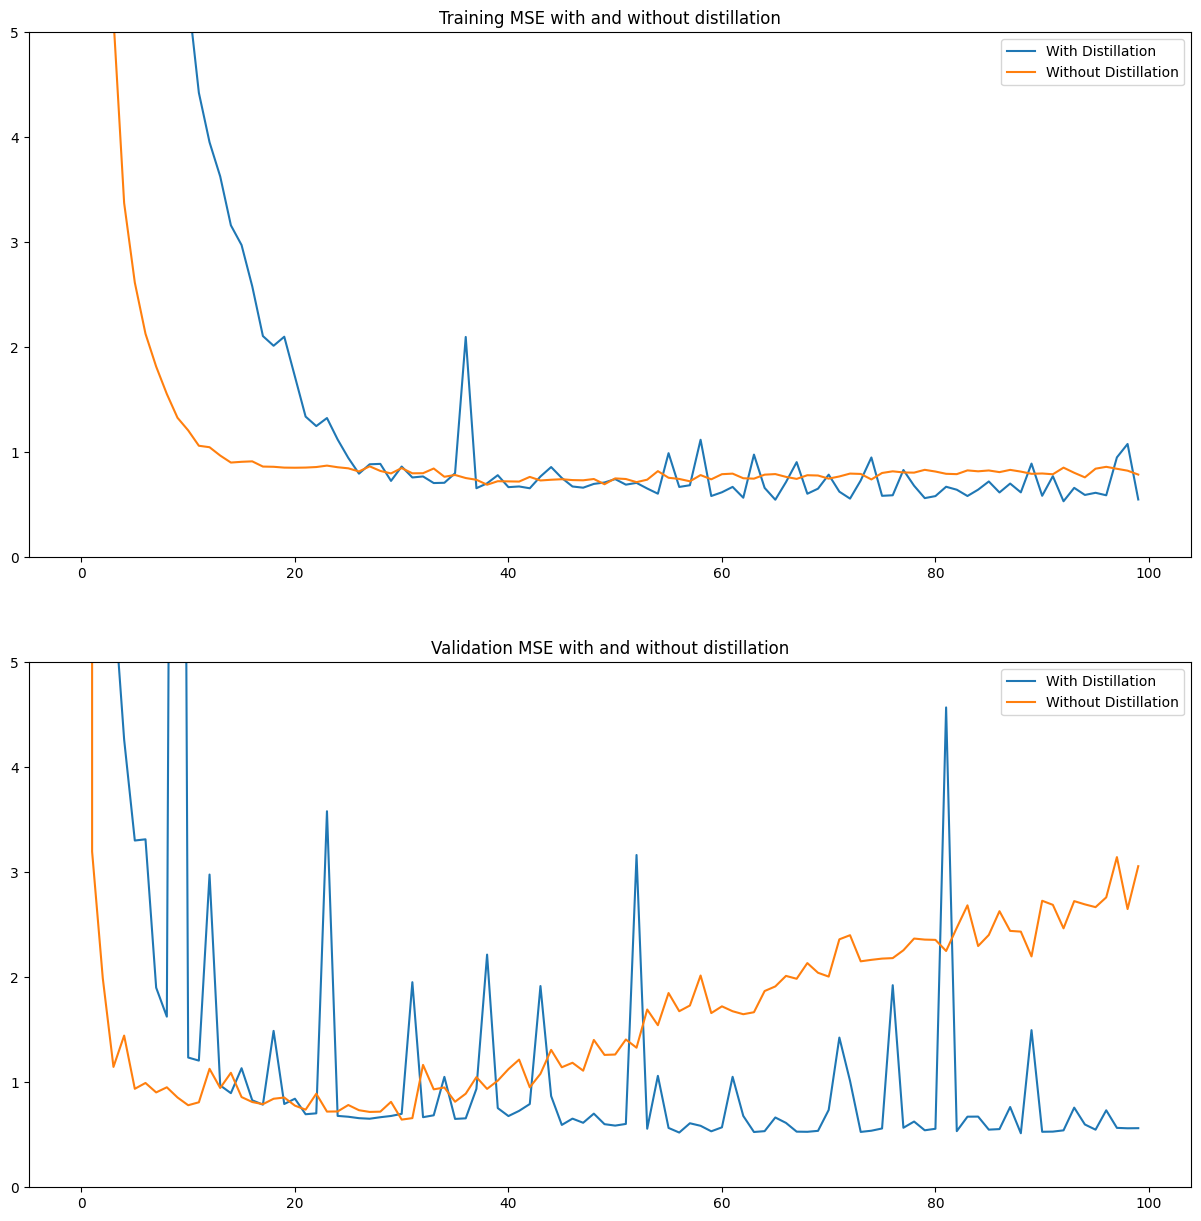

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5734 +- 0.1384
Validation mse without disstillation 0.6937 +- 0.3887


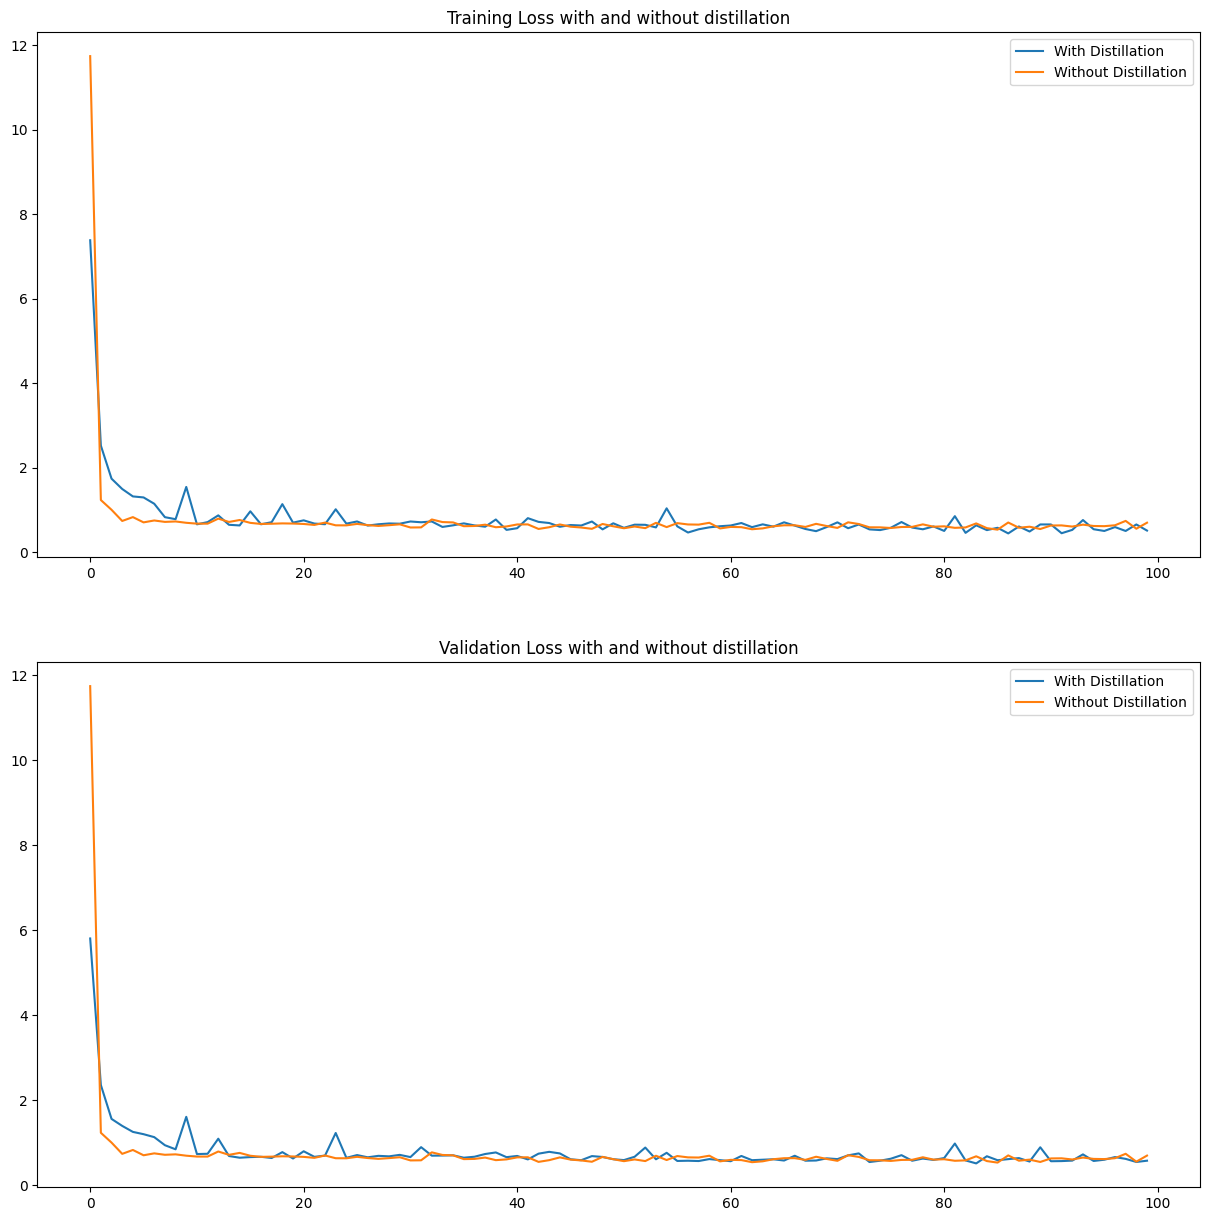

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [13]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
# Based on previous chart
distiller.fit(x_train, y_train, epochs=100)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=40)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 20086.1172 - mae: 61.3149 - mape: 4092.0962 - student_loss: 61.1219 - distillation_loss: 20019.1243
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 65.4798 - mae: 6.3423 - mape: 415.0869 - student_loss: 6.3353 - distillation_loss: 64.0771
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 40.5676 - mae: 4.9483 - mape: 320.3699 - student_loss: 4.9447 - distillation_loss: 39.3902
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 22.2977 - mae: 3.6575 - mape: 234.9203 - student_loss: 3.6564 - distillation_loss: 21.3633
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 12.1948 - mae: 2.6835 - mape: 172.4991 - student_loss: 2.6832 - distillation_loss: 11.4470
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 7.7235 - mae: 2.0756 - mape: 136.2302 - student_loss: 2.0755 - distillation_loss: 7.0888
Epo

492/492 [==============================] - 1s 2ms/step - mse: 0.8052 - mae: 0.6235 - mape: 40.6099 - student_loss: 0.6225 - distillation_loss: 0.3957
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.7955 - mae: 0.6386 - mape: 41.1342 - student_loss: 0.6396 - distillation_loss: 0.3805
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9573 - mae: 0.6906 - mape: 44.8360 - student_loss: 0.6902 - distillation_loss: 0.5472
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.7425 - mae: 0.6342 - mape: 41.1652 - student_loss: 0.6341 - distillation_loss: 0.3291
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8110 - mae: 0.6463 - mape: 41.9787 - student_loss: 0.6452 - distillation_loss: 0.3980
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.6719 - mae: 0.6011 - mape: 38.5259 - student_loss: 0.6015 - distillation_loss: 0.2682
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 178.6635 - mse: 78722.8359 - mae: 178.6635 - mape: 11915.7002
Epoch 2/40
492/492 [==============================] - 1s 2ms/step - loss: 10.8877 - mse: 474.8380 - mae: 10.8877 - mape: 724.1522
Epoch 3/40
492/492 [==============================] - 1s 2ms/step - loss: 2.0499 - mse: 7.6083 - mae: 2.0499 - mape: 117.5687
Epoch 4/40
492/492 [==============================] - 1s 2ms/step - loss: 1.5281 - mse: 3.9001 - mae: 1.5281 - mape: 80.6156
Epoch 5/40
492/492 [==============================] - 1s 2ms/step - loss: 0.9079 - mse: 1.5930 - mae: 0.9079 - mape: 54.8284
Epoch 6/40
492/492 [==============================] - 1s 2ms/step - loss: 0.6975 - mse: 0.8122 - mae: 0.6975 - mape: 47.1844
Epoch 7/40
492/492 [==============================] - 1s 2ms/step - loss: 0.6268 - mse: 0.6636 - mae: 0.6268 - mape: 42.1296
Epoch 8/40
492/492 [==============================] - 1s 2ms/step - loss: 0.5685 - mse: 0.5743 - mae: 0.5685 - mape: 36

In [14]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6292226314544678, 'mae': 0.5753554105758667, 'mape': 34.317935943603516, 'student_loss': 0.5730485916137695}
Test mse without disstillation {'loss': 0.5482744574546814, 'mse': 0.5691846013069153, 'mae': 0.5482744574546814, 'mape': 33.41350555419922}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
